In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
dataset_path = "/content/drive/MyDrive/data.pkl"
print(dataset_path)

/content/drive/MyDrive/data.pkl


In [3]:
from google.colab import drive
drive.mount('/content/drive')
import pickle
with open(dataset_path, 'rb') as file:
    data = pickle.load(file)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
(train_imgs, train_labels), (test_imgs, test_labels) = data

train_imgs = train_imgs.astype('float32') / 255.0
test_imgs = test_imgs.astype('float32') / 255.0

print(f"Training images shape: {train_imgs.shape}")
print(f"Training labels shape: {train_labels.shape}")
print(f"Test images shape: {test_imgs.shape}")
print(f"Test labels shape: {test_labels.shape}")

Training images shape: (4274, 256, 256, 3)
Training labels shape: (4274,)
Test images shape: (1069, 256, 256, 3)
Test labels shape: (1069,)


In [5]:
class_names =['AZIZ', 'MAHEDI', 'OLIVE', 'ZAFRUL']

In [6]:
from sklearn.model_selection import train_test_split

train_imgs, val_imgs, train_labels, val_labels = train_test_split(train_imgs, train_labels, test_size=0.2, random_state=42)

In [7]:
print(f"Training images shape: {train_imgs.shape}")
print(f"Training labels shape: {train_labels.shape}")
print(f"Validation images shape: {val_imgs.shape}")
print(f"Validation labels shape: {val_labels.shape}")

Training images shape: (3419, 256, 256, 3)
Training labels shape: (3419,)
Validation images shape: (855, 256, 256, 3)
Validation labels shape: (855,)


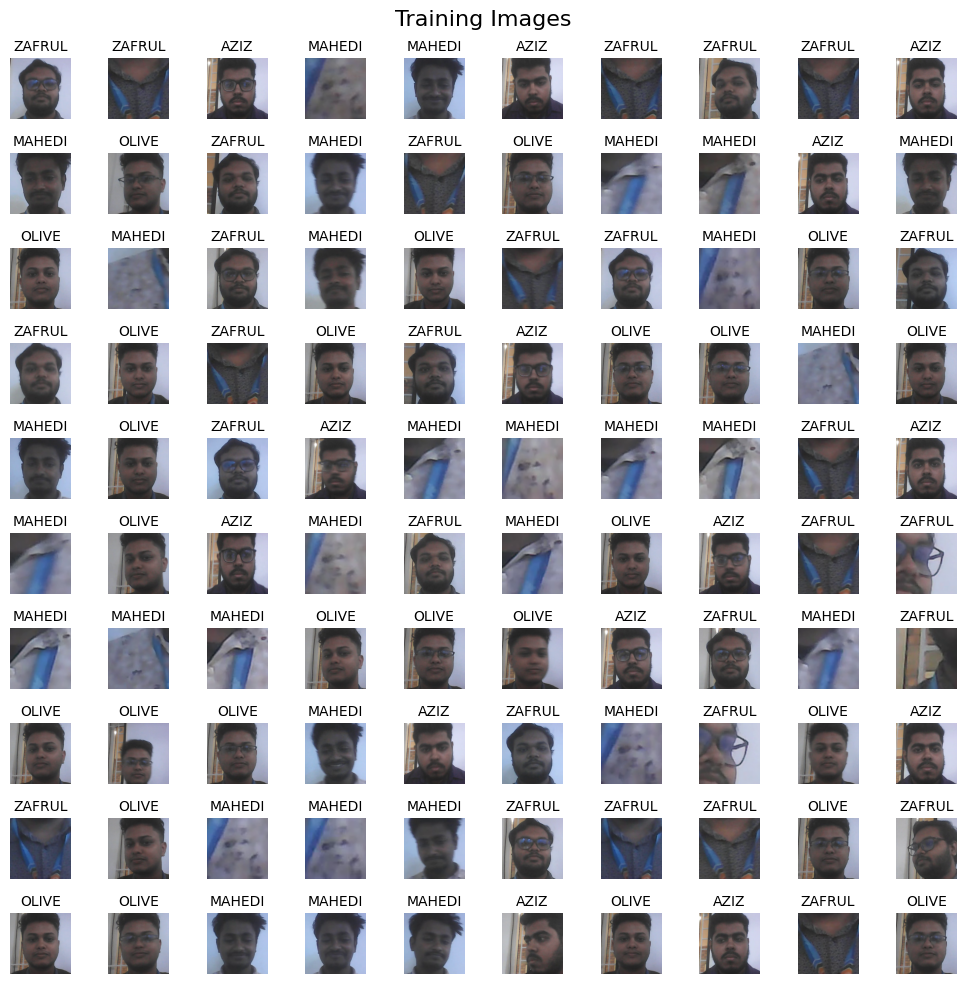

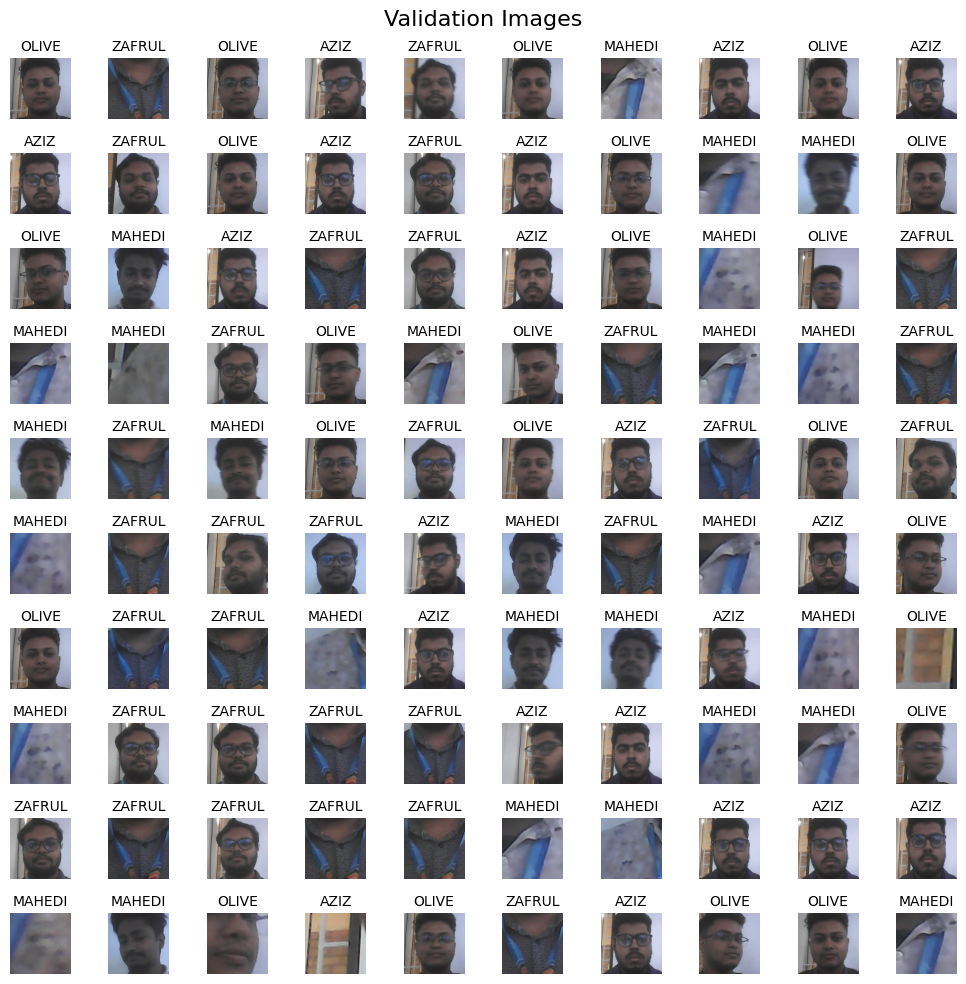

In [8]:
def plot_images(images, labels, title, class_names=None, num_images=100):
    grid_size = int(np.sqrt(num_images))

    # Select random images and labels
    idxs = np.random.choice(len(images), num_images, replace=False)
    selected_images = images[idxs]
    selected_labels = labels[idxs]

    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(grid_size, grid_size, i + 1)
        plt.imshow(selected_images[i])
        plt.axis('off')

        if class_names:
            plt.title(class_names[selected_labels[i]], fontsize=10)
        else:
            plt.title(selected_labels[i], fontsize=10)

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

plot_images(train_imgs, train_labels, title="Training Images", class_names=class_names)
plot_images(val_imgs, val_labels, title="Validation Images", class_names=class_names)

In [9]:
from tensorflow.keras import models, layers

model = models.Sequential([
    # Input Layer
    layers.Input(shape=(256, 256, 3)),

    # First Convolution Block
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Second Convolution Block
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Flatten before Dense Layers
    layers.Flatten(),

    # Dense Layers
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Helps prevent overfitting

    # Output Layer
    layers.Dense(4, activation='softmax')  # 4 classes for groupmates
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 256, 256, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 262144)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      33,554,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,574,468 (128.08 MB)

 Trainable params: 33,574,468 (128.08 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
from tensorflow.keras.optimizers import Adam
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [11]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)
datagen.fit(train_imgs)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(
    datagen.flow(train_imgs, train_labels, batch_size=12),
    epochs=50,
    validation_data=(val_imgs, val_labels),
    callbacks=[early_stopping],
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


285/285 ━━━━━━━━━━━━━━━━━━━━ 72s 220ms/step - accuracy: 0.3993 - loss: 1.4045 - val_accuracy: 0.8971 - val_loss: 0.7361
Epoch 2/50
285/285 ━━━━━━━━━━━━━━━━━━━━ 64s 183ms/step - accuracy: 0.6218 - loss: 0.8489 - val_accuracy: 0.8257 - val_loss: 0.3820
Epoch 3/50
285/285 ━━━━━━━━━━━━━━━━━━━━ 83s 188ms/step - accuracy: 0.6890 - loss: 0.6735 - val_accuracy: 0.9614 - val_loss: 0.3069
Epoch 4/50
285/285 ━━━━━━━━━━━━━━━━━━━━ 51s 177ms/step - accuracy: 0.7597 - loss: 0.5568 - val_accuracy: 0.9637 - val_loss: 0.2253
Epoch 5/50
285/285 ━━━━━━━━━━━━━━━━━━━━ 52s 177ms/step - accuracy: 0.7782 - loss: 0.5237 - val_accuracy: 0.9649 - val_loss: 0.1916
Epoch 6/50
285/285 ━━━━━━━━━━━━━━━━━━━━ 82s 177ms/step - accuracy: 0.7974 - loss: 0.4732 - val_accuracy: 0.9626 - val_loss: 0.1617
Epoch 7/50
285/285 ━━━━━━━━━━━━━━━━━━━━ 81s 176ms/step - accuracy: 0.8007 - loss: 0.4600 - val_accuracy: 0.9754 - val_loss: 0.1500
Epoch 8/50
285/285 ━━━━━━━━━━━━━━━━━━━━ 85s 187ms/step - accuracy: 0.8301 - loss: 0.3971 - val

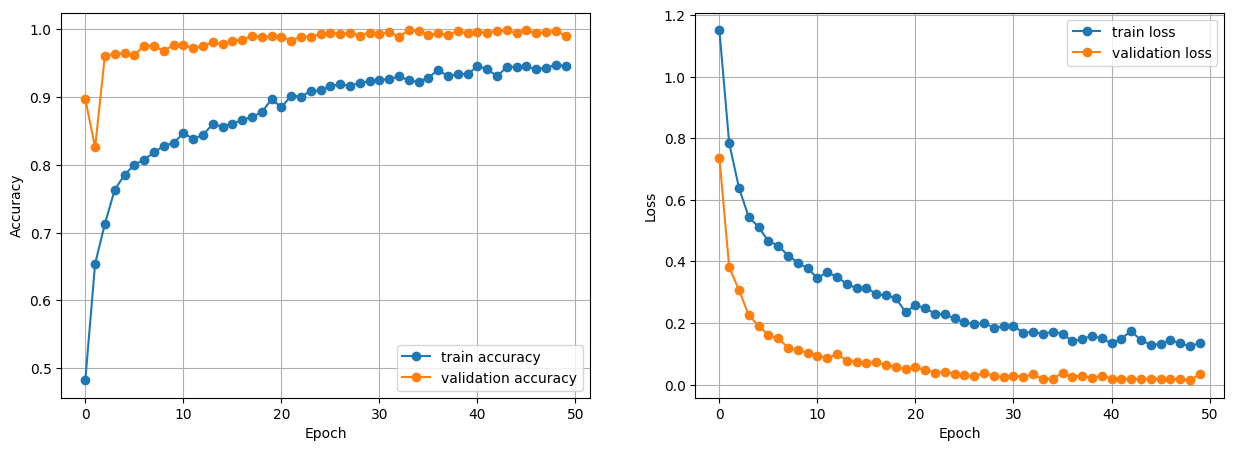

In [12]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], 'o-', label='train accuracy')
plt.plot(history.history['val_accuracy'], 'o-', label = 'validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], 'o-', label='train loss')
plt.plot(history.history['val_loss'], 'o-', label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend(loc='upper right')

plt.show()

In [13]:
test_loss, test_acc = model.evaluate(test_imgs, test_labels)
print('\nTest Accuracy:', test_acc)
print('\nTest Loss:', test_loss)

34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - accuracy: 0.9985 - loss: 0.0038

Test Accuracy: 0.9971936345100403

Test Loss: 0.005247027147561312


In [14]:
predictions = model.predict(test_imgs)

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


In [15]:
model.save('face_recognition_model.keras')